<a href="https://colab.research.google.com/github/LaizaCostaa/Case-An-lise-de-faturamento-Blog-x-Site/blob/main/previsao_receita_blog.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
import random
from sklearn.metrics import mean_absolute_error as mae

import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

df_antes_blog = pd.read_csv("df_antes_blog.csv")
df_antes_blog.head()

,data,receita,transacoes_blog,transacoes_site,usuarios_blog,usuarios_site,ano_mes,receita_site_prevista
0,2019-02-14,1340918,0,12798,0,96579,2019-02-01,1.281614e+06
1,2019-03-01,1689589,0,15577,0,97690,2019-03-01,1.426179e+06
2,2019-03-06,1688251,0,16212,0,105136,2019-03-01,1.459211e+06
3,2019-03-07,1877771,0,17793,0,108032,2019-03-01,1.541455e+06
4,2019-03-08,2453247,0,24376,0,109411,2019-03-01,1.883905e+06


In [ ]:
# Copiar as colunas 'receita' e 'data' para o novo DataFrame 'serie'
serie = df_antes_blog[['receita', 'data']].copy()

serie

,receita,data
0,1340918,2019-02-14
1,1689589,2019-03-01
2,1688251,2019-03-06
3,1877771,2019-03-07
4,2453247,2019-03-08
...,...,...
171,2944816,2020-05-27
172,2666364,2020-05-28
173,2694096,2020-05-29
174,2215956,2020-05-30


1. **CONHECENDO A SÉRIE ANTES DE APLICAR O MODELO**

Nesta etapa, iremos:

*  Verificar a estacionariedade da série
*  Aplicar ACF e PACF para definir os parâmetros p,d,q

In [ ]:
from statsmodels.tsa.stattools import adfuller

# Aplicar o teste ADF
resultado_adf = adfuller(df_antes_blog['receita'])

# Extrair os resultados do teste ADF
estatistica_teste = resultado_adf[0]
valor_p = resultado_adf[1]
valores_criticos = resultado_adf[4]

# Imprimir os resultados
print('Estatística do teste ADF:', estatistica_teste)
print('Valor-p:', valor_p)
print('Valores críticos:')
for chave, valor in valores_criticos.items():
    print('\t', chave, ':', valor)

Estatística do teste ADF: -1.99290605153011
Valor-p: 0.2896921846535939
Valores críticos:
	 1% : -3.469413468959902
	 5% : -2.8786964197028295
	 10% : -2.5759166089965397


In [ ]:
# Verificar se a série é estacionária ou não
if valor_p < 0.05:
    print('A série é estacionária')
else:
    print('A série não é estacionária')

A série não é estacionária


In [ ]:
import pandas.util.testing as tm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from matplotlib import pyplot


In [ ]:
from statsmodels.graphics.tsaplots import plot_acf

# Converter a coluna 'receita' para tipo numérico
serie['receita'] = pd.to_numeric(serie['receita'])


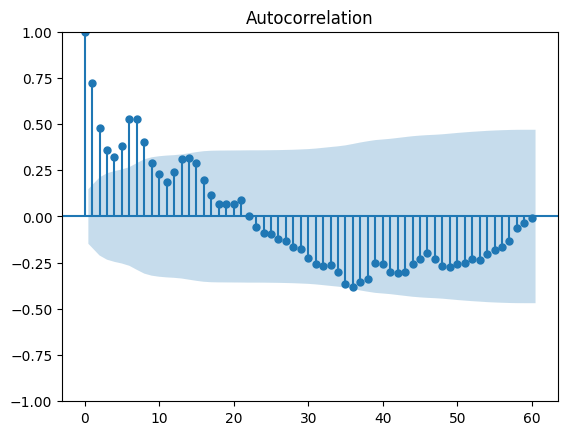

In [ ]:

# Plotar a função de autocorrelação
plot_acf(serie['receita'], lags=60)
plt.show()

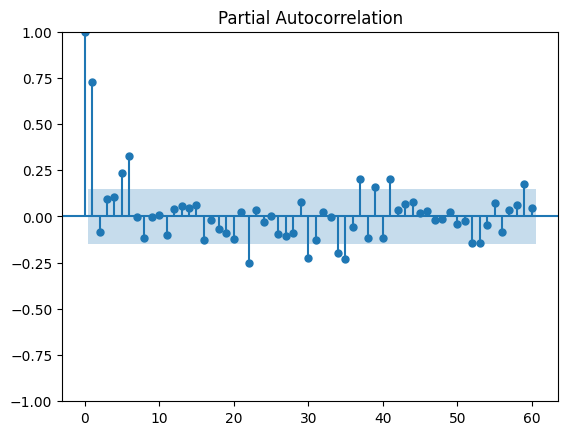

In [ ]:

# Plotar a função de autocorrelação parcial
plot_pacf(serie['receita'], lags=60)
plt.show()

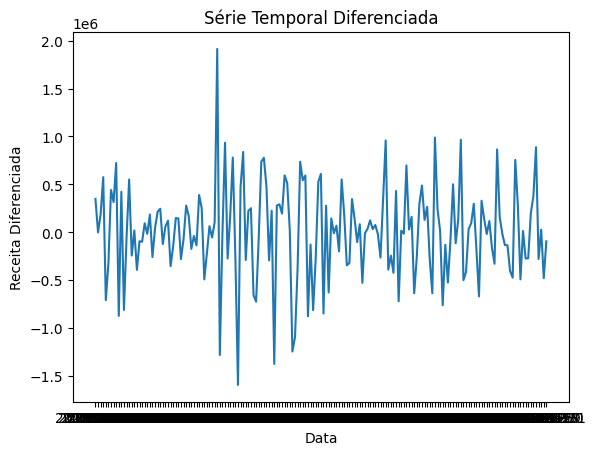

In [ ]:
# Fazer uma cópia da coluna 'receita' para uma nova coluna 'receita_diferenciada'
serie['receita_diferenciada'] = serie['receita'].diff()

# Remover a primeira linha que conterá um valor NaN após a diferenciação
serie = serie.dropna()

plt.plot(serie['data'], serie['receita_diferenciada'])
plt.xlabel('Data')
plt.ylabel('Receita Diferenciada')
plt.title('Série Temporal Diferenciada')
plt.show()

In [ ]:
from statsmodels.tsa.arima.model import ARIMA
# Ajustar o modelo ARIMA com os dados de treinamento
modelo = ARIMA(serie['receita'], order=(1, 1, 1))
modelo_treinado = modelo.fit()

# Fazer a previsão dos próximos 4 meses a partir de junho
ultima_data = pd.to_datetime(serie['data'].max())
data_inicial = ultima_data + pd.DateOffset(months=1)
indices = pd.date_range(start=data_inicial, periods=4, freq='MS')
previsao = modelo_treinado.get_forecast(steps=4)


In [ ]:
# Obter os valores previstos e os intervalos de confiança
valores_previstos = previsao.predicted_mean
intervalo_inferior = previsao.conf_int()['lower receita']
intervalo_superior = previsao.conf_int()['upper receita']

In [ ]:
# Criar DataFrame com os resultados da previsão
df_previsao = pd.DataFrame({
    'Data': indices,
    'Receita Prevista': valores_previstos,
    'Intervalo Inferior': intervalo_inferior,
    'Intervalo Superior': intervalo_superior
})


df_previsao

,Data,Receita Prevista,Intervalo Inferior,Intervalo Superior
175,2020-07-01,2.152641e+06,1.226030e+06,3.079252e+06
176,2020-08-01,2.169971e+06,1.044070e+06,3.295872e+06
177,2020-09-01,2.179908e+06,9.579232e+05,3.401893e+06
178,2020-10-01,2.185607e+06,9.057273e+05,3.465486e+06


In [ ]:
df_previsao['Data'] = pd.to_datetime(df_previsao['Data'])

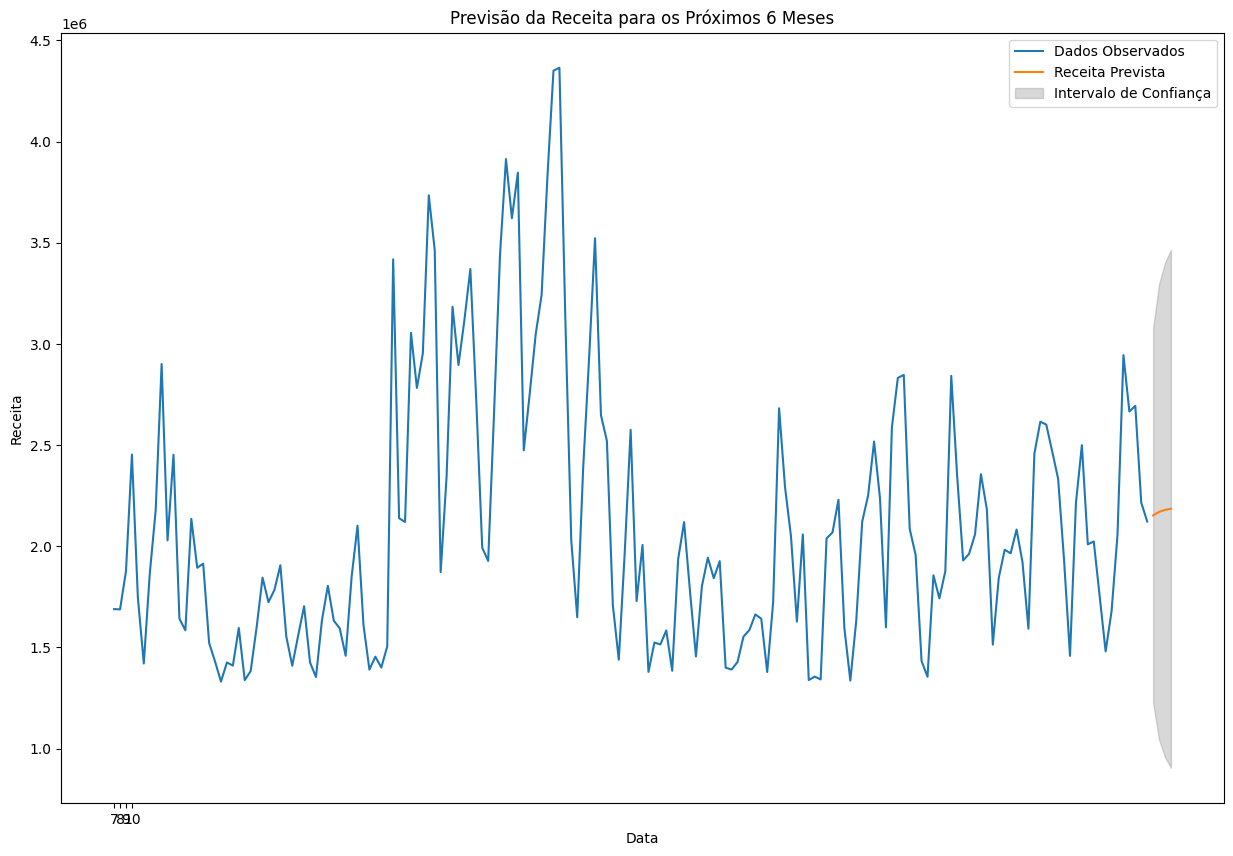

In [ ]:
fig, ax = plt.subplots(figsize=(15, 10))

plt.plot(serie['data'], serie['receita'], label='Dados Observados')
df_previsao['Data'] = pd.to_datetime(df_previsao['Data'])
plt.plot(df_previsao['Data'].astype(str), df_previsao['Receita Prevista'], label='Receita Prevista')
plt.fill_between(df_previsao['Data'].astype(str), df_previsao['Intervalo Inferior'], df_previsao['Intervalo Superior'],
                 color='gray', alpha=0.3, label='Intervalo de Confiança')
plt.xlabel('Data')
plt.ylabel('Receita')
plt.title('Previsão da Receita para os Próximos 6 Meses')
plt.legend()

# Obter os índices dos meses
meses = df_previsao['Data'].dt.month

# Definir os ticks e labels dos meses
plt.gca().set_xticks(range(len(meses)))
plt.gca().set_xticklabels(meses)

plt.show()

In [ ]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression

# Carregar o conjunto de dados California Housing
X, y = fetch_california_housing(return_X_y=True, as_frame=True)

# Criar um modelo de regressão linear
modelo = LinearRegression()

# Realizar a validação cruzada com 5 folds
scores = cross_val_score(modelo, X, y, cv=5, scoring='neg_mean_squared_error')

# Converter os scores de erro quadrático médio negativo para erro quadrático médio positivo
mse_scores = -scores

# Calcular a média e o desvio padrão dos erros quadráticos médios
mean_mse = mse_scores.mean()
std_mse = mse_scores.std()

# Imprimir os resultados
print("Erros Quadráticos Médios:")
print(mse_scores)
print("Média do Erro Quadrático Médio:", mean_mse)
print("Desvio Padrão do Erro Quadrático Médio:", std_mse)

Erros Quadráticos Médios:
[0.48485857 0.62249739 0.64621047 0.5431996  0.49468484]
Média do Erro Quadrático Médio: 0.5582901717686546
Desvio Padrão do Erro Quadrático Médio: 0.06560199778318038


In [ ]:
df_depois_blog = pd.read_csv("df_depois_blog.csv")
df_depois_blog.head()

,data,receita,transacoes_blog,transacoes_site,usuarios_blog,usuarios_site,ano_mes
0,2020-06-01,2166784,301,29095,856,131209,2020-06-01
1,2020-06-02,2325207,458,31840,697,157032,2020-06-01
2,2020-06-03,2689781,435,33739,521,142649,2020-06-01
3,2020-06-04,2458059,599,33464,1449,153545,2020-06-01
4,2020-06-05,2461542,870,28136,1066,136153,2020-06-01


In [ ]:
from sklearn.metrics import mean_absolute_error


In [ ]:
df_depois_blog['data'] = pd.to_datetime(df_depois_blog['data'])

In [ ]:
df_depois_blog.head()

,data,receita,transacoes_blog,transacoes_site,usuarios_blog,usuarios_site,ano_mes
0,2020-06-01,2166784,301,29095,856,131209,2020-06-01
1,2020-06-02,2325207,458,31840,697,157032,2020-06-01
2,2020-06-03,2689781,435,33739,521,142649,2020-06-01
3,2020-06-04,2458059,599,33464,1449,153545,2020-06-01
4,2020-06-05,2461542,870,28136,1066,136153,2020-06-01


In [ ]:
df_depois_blog.dtypes

data               datetime64[ns]
receita                     int64
transacoes_blog             int64
transacoes_site             int64
usuarios_blog               int64
usuarios_site               int64
ano_mes                    object
dtype: object

In [ ]:
df_depois_blog

,data,receita,transacoes_blog,transacoes_site,usuarios_blog,usuarios_site,ano_mes
0,2020-06-01,2166784,301,29095,856,131209,2020-06-01
1,2020-06-02,2325207,458,31840,697,157032,2020-06-01
2,2020-06-03,2689781,435,33739,521,142649,2020-06-01
3,2020-06-04,2458059,599,33464,1449,153545,2020-06-01
4,2020-06-05,2461542,870,28136,1066,136153,2020-06-01
...,...,...,...,...,...,...,...
112,2020-09-24,3648743,2379,22807,11700,130853,2020-09-01
113,2020-09-25,3320034,1996,21578,10082,112163,2020-09-01
114,2020-09-26,2509687,1580,15320,9292,96178,2020-09-01
115,2020-09-27,2182679,1838,14135,10052,103494,2020-09-01


In [ ]:

df_agrupado = df_depois_blog.groupby(pd.Grouper(key='data', freq='M')).mean()

In [ ]:
df_agrupado

,receita,transacoes_blog,transacoes_site,usuarios_blog,usuarios_site
data,,,,,
2020-06-30,2.715258e+06,1419.666667,24110.633333,2483.533333,121649.966667
2020-07-31,2.887969e+06,3727.225806,20558.322581,6122.387097,108790.838710
2020-08-31,2.763311e+06,3354.666667,19082.766667,10647.700000,113624.933333
2020-09-30,2.885878e+06,2391.807692,19183.346154,10752.076923,112815.307692


In [ ]:
valores_reais = df_agrupado.reset_index()[['data', 'receita']].copy()
valores_reais

,data,receita
0,2020-06-30,2.715258e+06
1,2020-07-31,2.887969e+06
2,2020-08-31,2.763311e+06
3,2020-09-30,2.885878e+06


In [ ]:
df_previsao.head()

,Data,Receita Prevista,Intervalo Inferior,Intervalo Superior
175,2020-07-01,2.152641e+06,1.226030e+06,3.079252e+06
176,2020-08-01,2.169971e+06,1.044070e+06,3.295872e+06
177,2020-09-01,2.179908e+06,9.579232e+05,3.401893e+06
178,2020-10-01,2.185607e+06,9.057273e+05,3.465486e+06


In [ ]:
valores_reais['receita'] = valores_reais['receita'].astype(float)  # Converter para tipo de dados numérico

In [ ]:
valores_reais

,data,receita
0,2020-06-30,2.715258e+06
1,2020-07-31,2.887969e+06
2,2020-08-31,2.763311e+06
3,2020-09-30,2.885878e+06


In [ ]:
valores_reais.dtypes

data       datetime64[ns]
receita           float64
dtype: object

In [ ]:
df_previsao

,Data,Receita Prevista,Intervalo Inferior,Intervalo Superior
175,2020-07-01,2.152641e+06,1.226030e+06,3.079252e+06
176,2020-08-01,2.169971e+06,1.044070e+06,3.295872e+06
177,2020-09-01,2.179908e+06,9.579232e+05,3.401893e+06
178,2020-10-01,2.185607e+06,9.057273e+05,3.465486e+06


In [ ]:
df_previsao.head()

,Data,Receita Prevista,Intervalo Inferior,Intervalo Superior
175,2020-07-01,2.152641e+06,1.226030e+06,3.079252e+06
176,2020-08-01,2.169971e+06,1.044070e+06,3.295872e+06
177,2020-09-01,2.179908e+06,9.579232e+05,3.401893e+06
178,2020-10-01,2.185607e+06,9.057273e+05,3.465486e+06


In [ ]:
df_valores_previstos = df_previsao[['Data', 'Receita Prevista']]
df_valores_previstos

,Data,Receita Prevista
175,2020-07-01,2.152641e+06
176,2020-08-01,2.169971e+06
177,2020-09-01,2.179908e+06
178,2020-10-01,2.185607e+06


In [ ]:
df_valores_previstos.dtypes

Data                datetime64[ns]
Receita Prevista           float64
dtype: object

In [ ]:
valores_reais

,data,receita
0,2020-06-30,2.715258e+06
1,2020-07-31,2.887969e+06
2,2020-08-31,2.763311e+06
3,2020-09-30,2.885878e+06


Os valores reais estão próximos dos valores previstos

In [ ]:
from sklearn.metrics import mean_absolute_error

In [ ]:
mae = mean_absolute_error(valores_reais['receita'], df_valores_previstos['Receita Prevista'])

print("Erro Médio Absoluto (MAE):", mae)

Erro Médio Absoluto (MAE): 641072.5415563462


In [ ]:
receita_total = pd.read_csv('receita_total.csv')
receita_total

,data,receita
0,2019-02-14,1340918.0
1,2019-03-01,1689589.0
2,2019-03-06,1688251.0
3,2019-03-07,1877771.0
4,2019-03-08,2453247.0
...,...,...
288,2020-09-24,3648743.0
289,2020-09-25,3320034.0
290,2020-09-26,2509687.0
291,2020-09-27,2182679.0


In [ ]:
receita_total['data'] = pd.to_datetime(receita_total['data'])

In [ ]:
#Extraindo ano mÊs da receita
receita_total['year'] = receita_total['data'].dt.year
receita_total['month'] = receita_total['data'].dt.month
receita_total['day'] = 1


In [ ]:
#Calculando a média da receita por ano e mêS
receita_media_mensal = receita_total.groupby(['year','month', 'day'])['receita'].mean()

In [ ]:
receita_media_mensal

year  month  day
2019  2      1      1.340918e+06
      3      1      1.912406e+06
      6      1      1.389248e+06
      7      1      1.596190e+06
      8      1      1.618884e+06
      9      1      1.586906e+06
      11     1      2.960518e+06
      12     1      2.559219e+06
2020  1      1      1.477535e+06
      2      1      1.729298e+06
      3      1      1.755740e+06
      4      1      2.068161e+06
      5      1      2.115849e+06
      6      1      2.715258e+06
      7      1      2.887969e+06
      8      1      2.763311e+06
      9      1      2.885878e+06
Name: receita, dtype: float64

In [ ]:
receita_media_mensal = receita_media_mensal.reset_index()

receita_media_mensal['Data'] = pd.to_datetime(receita_media_mensal[['year', 'month', 'day']])
receita_media_mensal = receita_media_mensal[['Data', 'receita']]
receita_media_mensal

,Data,receita
0,2019-02-01,1.340918e+06
1,2019-03-01,1.912406e+06
2,2019-06-01,1.389248e+06
3,2019-07-01,1.596190e+06
4,2019-08-01,1.618884e+06
5,2019-09-01,1.586906e+06
6,2019-11-01,2.960518e+06
7,2019-12-01,2.559219e+06
8,2020-01-01,1.477535e+06
9,2020-02-01,1.729298e+06


In [ ]:
df_valores_previstos

,Data,Receita Prevista
175,2020-07-01,2.152641e+06
176,2020-08-01,2.169971e+06
177,2020-09-01,2.179908e+06
178,2020-10-01,2.185607e+06


In [ ]:
receita_media_mensal.dtypes

Data       datetime64[ns]
receita           float64
dtype: object

In [ ]:
receita_media_mensal_total =  receita_media_mensal.merge(df_valores_previstos, on='Data' , how='left')
receita_media_mensal_total

,Data,receita,Receita Prevista
0,2019-02-01,1.340918e+06,NaN
1,2019-03-01,1.912406e+06,NaN
2,2019-06-01,1.389248e+06,NaN
3,2019-07-01,1.596190e+06,NaN
4,2019-08-01,1.618884e+06,NaN
5,2019-09-01,1.586906e+06,NaN
6,2019-11-01,2.960518e+06,NaN
7,2019-12-01,2.559219e+06,NaN
8,2020-01-01,1.477535e+06,NaN
9,2020-02-01,1.729298e+06,NaN


In [ ]:
receita_media_mensal_total['Receita Prevista'] = receita_media_mensal_total['Receita Prevista'].fillna(0)
receita_media_mensal_total['receita'] = receita_media_mensal_total['receita'].fillna(0)
receita_media_mensal_total

,Data,receita,Receita Prevista
0,2019-02-01,1.340918e+06,0.000000e+00
1,2019-03-01,1.912406e+06,0.000000e+00
2,2019-06-01,1.389248e+06,0.000000e+00
3,2019-07-01,1.596190e+06,0.000000e+00
4,2019-08-01,1.618884e+06,0.000000e+00
5,2019-09-01,1.586906e+06,0.000000e+00
6,2019-11-01,2.960518e+06,0.000000e+00
7,2019-12-01,2.559219e+06,0.000000e+00
8,2020-01-01,1.477535e+06,0.000000e+00
9,2020-02-01,1.729298e+06,0.000000e+00


In [ ]:
receita_media_mensal_total['receita_blog'] = receita_media_mensal_total['receita'] - receita_media_mensal_total['Receita Prevista']
receita_media_mensal_total

,Data,receita,Receita Prevista,receita_blog
0,2019-02-01,1.340918e+06,0.000000e+00,1.340918e+06
1,2019-03-01,1.912406e+06,0.000000e+00,1.912406e+06
2,2019-06-01,1.389248e+06,0.000000e+00,1.389248e+06
3,2019-07-01,1.596190e+06,0.000000e+00,1.596190e+06
4,2019-08-01,1.618884e+06,0.000000e+00,1.618884e+06
5,2019-09-01,1.586906e+06,0.000000e+00,1.586906e+06
6,2019-11-01,2.960518e+06,0.000000e+00,2.960518e+06
7,2019-12-01,2.559219e+06,0.000000e+00,2.559219e+06
8,2020-01-01,1.477535e+06,0.000000e+00,1.477535e+06
9,2020-02-01,1.729298e+06,0.000000e+00,1.729298e+06
